In [30]:
%matplotlib inline
import scipy.special as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

In [90]:
# Parameters
v0=8.0
nwind = 33
wind=np.arange(254,287)
b=np.array((1,5,1000))

In [65]:
#Simple Attenuation fn
def att(dist, ang, b):
    # angular part
    angular=np.where(b[1]*np.abs(ang)<np.pi/2.,np.square(np.cos(b[1]*ang)),0.)
    #radial
    radial=np.exp(-np.square(dist/b[2]))
    return 1.0-b[0]*angular*radial

0.039565551245765218

In [33]:
v=np.loadtxt('hornsrev_data_all.txt')

vxref=v[:,3]
vyref=v[:,4]
angles=v[:,0]
vmean=np.sqrt(np.square(vxref)+np.square(vyref))
vmean=pd.DataFrame(vmean)
vref=pd.DataFrame()
vmean['angle']=angles
vref=vref.append(vmean)
vref=vref.groupby('angle')
vref.groups
vref.describe()
vref.get_group(260).iat[50,0]
#vref.iat[5,0]
#vref.groupby('angle')


6.5129137071193028

In [87]:
vref.get_group(256).iat[0,0]

7.5954094255732185

In [113]:
coords_in = np.loadtxt('coords.txt')
#print(min(coords_in[:,0]), min(coords_in[:,1]))
xmin = min(coords_in[:,0])
ymin = min(coords_in[:,1])

xzero = (max(coords_in[:,0])-xmin)/2
yzero = (max(coords_in[:,1])-ymin)/2
#print(xzero, yzero)

coords_x=coords_in[:,0]-xzero-xmin
coords_y=coords_in[:,1]-yzero-ymin
coords=[coords_x,coords_y]
coords=np.array(coords).T
nturb=np.shape(coords)[0]
#plt.scatter(coords[:,0], coords[:,1])

#Arrays for pairwise distances and angles
#Angle 0: x directıon. Angle pi/2: y directıon
distance=np.zeros((nturb,nturb))
angle=np.zeros((nturb,nturb))
for i in range(0,nturb):
    distance[i,:]=np.sqrt(np.square(coords[i,0]-coords[:,0])+np.square(coords[i,1]-coords[:,1]))
    angle[i,:]=np.arctan2(coords[:,1]-coords[i,1],coords[:,0]-coords[i,0])
#Rotate angles so that north=0 and convert to degrees
angle=-np.rad2deg(angle)+270
angle[0,1]

#Rotating angles to wind direction
windangle=5 #degrees
rotangles=np.mod(angle-windangle+180,360)-180

(np.sort(distance))[0,2]

561.11050605027879

In [119]:
i=0
j=8
print('Turbine {} x {} y {}'.format(i,coords[i,0],coords[i,1]))
print('Turbine {} x {} y {}'.format(j,coords[j,0],coords[j,1]))
print('{}-{} dist {} angle {}'.format(i,j,distance[i,j], angle[i,j]))

Turbine 0 x -2728.5 y 1952.0
Turbine 8 x -2168.5 y 1952.0
0-8 dist 560.0 angle 270.0


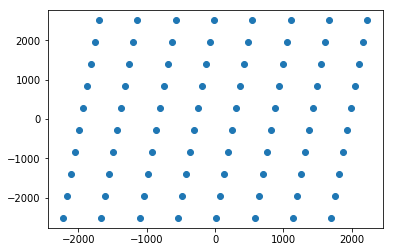

In [35]:
def rotate(angle,coords):
    angle = np.pi*angle/180.
    rotcoordx = []
    rotcoordy = []
    for coord in coords:
        rotcoordx+=[coord[0]*np.cos(angle)-coord[1]*np.sin(angle)]
        rotcoordy+=[coord[0]*np.sin(angle)+coord[1]*np.cos(angle)]
    rotcoords=[rotcoordx,rotcoordy]
    rotcoords=np.array(rotcoords).T   
    return rotcoords 
#print rotate(254,coords)[:,0]
plt.scatter(rotate(264,coords)[:,0],rotate(264,coords)[:,1])

In [123]:
#Total att
def deviation(b):
    total_att=np.ones((nturb,nwind))
    deviation=0
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]*att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,b)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            deviation=deviation+np.square(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return deviation

[[  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   1.41253439e-01
    1.60273696e-01   0.00000000e+00]
 [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   1.60041615e-01
    1.77351631e-01   1.95918957e-01]
 [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   2.14355668e-01
    2.26899828e-01   2.41161173e-01]
 ..., 
 [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   1.84220905e-01
    1.84427755e-01   1.87520082e-01]
 [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   9.38217327e-02
    1.02820739e-01   1.13631489e-01]
 [  0.00000000e+00   7.51689487e-04   3.00336942e-03 ...,   6.14842818e-02
    7.39187328e-02   8.76679289e-02]]


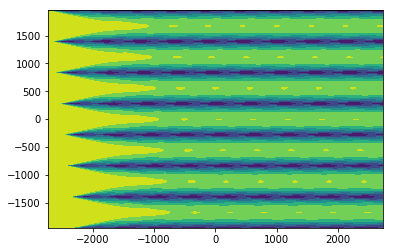

In [121]:
#Plot attenuation
xsamp = np.linspace(min(coords_x), max(coords_x), 200)
ysamp = np.linspace(min(coords_y), max(coords_y), 200)

x,y = np.meshgrid(xsamp,ysamp)
distances=np.empty_like(x)
angles=np.empty_like(x)
values=np.empty_like(x)
values=1.0

for j in range(0,nturb):
    distances=np.sqrt(np.square(coords[j,0]-x)+np.square(coords[j,1]-y))
    angles=np.arctan2(y-coords[j,1],x-coords[j,0])+0/180*np.pi
    values = values*att(distances,angles,b) #np.mod(angles-wind[k]+np.pi,np.pi*2)-np.pi,b)

print(values)

#-- Plot... ------------------------------------------------
fig, ax = plt.subplots()
ax.contourf(x, y, values)

plt.show()

In [129]:
res=minimize(deviation,b)

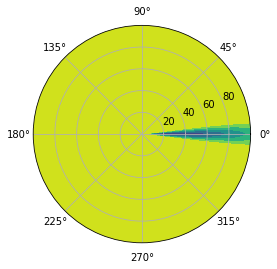

In [46]:
azimuths = np.radians(np.linspace(-180, 180, 360))
zeniths = np.arange(0, 100, .1)

r, theta = np.meshgrid(zeniths, azimuths)
values = att(r,theta,b)

#-- Plot... ------------------------------------------------
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.contourf(theta, r, values)

plt.show()

In [130]:
res

      fun: 693.2520043125913
 hess_inv: array([[  6.97609098e-06,   2.11229316e-04,  -2.77146380e-02],
       [  2.11229316e-04,   2.54103467e-02,   3.17495730e+00],
       [ -2.77146380e-02,   3.17495730e+00,   1.43997108e+03]])
      jac: array([  1.92787170e-01,  -2.21252441e-03,   2.28881836e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 607
      nit: 40
     njev: 119
   status: 2
  success: False
        x: array([  1.40002561e-01,   8.51478121e+00,   2.62606729e+03])